## Analysis of Hollywood Evolution

How does the hollywood network look like and how has it changed over time

In this section we will dive into the network and explore different attributes of the network, to gain insights on the elite of Hollywood. This will be structured into the 6 subsections listed below.

* Investigation of the network - Get at reference point to some of the well known and documented networks
    * [x] Links
    * [x] In and out degree
    * [x] Visualisation of the entire network with relevant attributes - SHOULD BE IMPROVED
    * [ ] Comparison with Random Network
    * [ ] Changes in degree distribution over time
    
* Genre - How are the top of Hollywood distributed across genres
    * [x] Genre distribution over time
    * [x] Genre popularity compared to average budget
    * [ ] Particular patterns of actors work in genres - Asbjørn

* Important words - What words stand out using TF-IDF schemas of the decades and across genres and decase
    * [x] TF-IDF
    * [x] Relation to dominant genres
    * [x] Wordclouds
    * [ ] Most important words -> similarity with the decades wikipedia page

* Sentiment - How do people interpet the words of these segmentations?
    * [ ] How does it relate to the TF-IDF
    * [ ] Does it reflect the major events of the us/world?

* Actor communities - What actors constitute movie communities and how has this changes over time?
    * [ ] Are the communities high budget highly rated?

* Wrapup - Can we generalize the trends in hollywood?


In [1]:
from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime
from ipywidgets import *
import ipywidgets as widgets
import time
import math
from nltk.corpus import stopwords
from PIL import Image
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
import warnings
import copy
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import sys
sys.path.append('./Jupyter')
from helpers import *



#Init stopwords
stop_words = set(stopwords.words('english'))

In [2]:
try:
    from fa2 import ForceAtlas2
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    import gif
except:
    pass

In [9]:
df, G = create_df_G_from_path("")

# <span style="color:red">Actor communities</span>

## Analysis of Actor Communities

As presented in project assignment A, we have a theory that there exist small communities within Hollywood, where groups of actors do the majority of their work together in specific genres. The reasoning behind this is e.g. typacal actionfilm actors often end up starring together, simply because they prefer the same genre.

In general terms, this section will uncover the communities of Hollywood, and investigate whether communities are genre dependent. 

To find the communities it has been chosen to use the Louvain algorithm. The following section will elaborate on why we've chosen this algorithm in particular.

<b>Modularity</b>

Before diving into the Louvain algorithm, we must understand what it tries to partition the graph on. Modularity is a measure of how connected a group of nodes are, compared to how connected they're expected to be. The formula for modularity is given by:

$$M = \sum_{n=0}^{n_c} \left[ \frac{L_c}{L} - \frac{k_c}{2L}^2 \right]$$

$L = $ Total number of links,
$L_c = $ Number of links in community $c$,
$n_c = $ Number of communities,
$k_c = $ Total degree of the community $c$.

If we remove the sum, and thus only investigate the modularity of 1 community, we can that a community gets a high modularity score, if they are 1) very connected to one another, and 2) not very connected to nodes outside the community. With expectation is meant, how connected we expect 2 nodes to be, if the network is randomly wired.

In our case, having a weighted graph, $L_c$ will be equal to the sum of weights inside community $c$, whereas $L$ will be equal to the total sum of weights in the whole network.

<b>Louvain Algorithm</b>

Having covered modularity, it seems reasonable to choose communities by maximixing modularity. Finding a best partition of a graph is by nature a hard problem, but the Louvain algorithm is an approximate method, which can gives a running time of $O(L)$.

In simple terms, the louvain algorithm initially finds, for each node, the "best" neighboor with regards to modularity, that is, connecting to the node that causes the largest positive change in modularity, $\Delta M$. We do this repeatedly, until $\Delta M = 0$. Then the nodes in a community are merged into 1 node, with all their internal edges as self-loops, and the whole process is continuously repeated, until $\Delta M = 0$.

The order in which we consider the nodes are random, and therefore the algorithm is not deterministic. This an approximate method, because optimizing the modularity locally, by finding the best neighboor, is not guaranteed to give the best result globally. However, the algorithm is very popular, because it often finds a satisfactory partition, and because it is very fast.

<b>Modularity and Resolution Limit</b>

Maximizing modularity will have difficulties finding communities smaller than the resolution limit, which is given by the formula:

$$k \leq \sqrt{2L}$$

In our case, this means, with our $L = 22415$, that we are going to have communities of  approximately size $212$. It is very hard to say something general about a network of actors of this size, thus we will force smaller communities. This is done by treating each community as a network itself, and then running the algorithm on this subgraph. Implementation-wise this magic has been done for us, where resolution is provided as a tuneable hyperparameter of the Louvain algorithm.

### Community Detection

In this section we will detect our communities, and do so by forcing smaller communities than the resolution limit.

In [16]:
import community as community_louvain
import networkx.algorithms.community as nx_comm

In [17]:
def get_modularity(community_dict):
    comvalues = np.array(list(community_dict.values()))
    comkeys = np.array(list(community_dict.keys()))
    
    
    l = []
    
    for i in np.unique(comvalues):
        comkey_indices = np.where(comvalues == i)[0]
        l1 = set()
        for j in comkey_indices:
            l1.add(comkeys[j])
        l.append(l1)
        
    return nx_comm.modularity(G, l)

<b>Choosing the resolution</b>

We explore the modularity as a function of resolution. From this we pick a suitable resolution, which yields satisfactory community sizes.

As previously stated, we use the Louvain algorithm.

In [63]:
def get_best_coms(Graph):
    best_mod = -2
    res = np.linspace(10**-1, 0.7, num=20)
    mod_scores = []
    best_res = res[0]
    for i in res:
        new_mod = get_modularity(community_louvain.best_partition(Graph, resolution=i))
        mod_scores.append(new_mod)
        if new_mod > best_mod:
            best_mod = new_mod
            best_res = i
    
    return res, mod_scores, community_louvain.best_partition(Graph, resolution=best_res)

In [64]:
Res, mod_Scores, com_dict = get_best_coms(G)

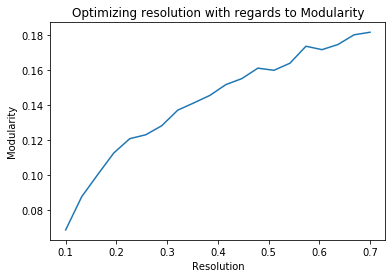

In [65]:
plt.plot(Res, mod_Scores)
plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.title('Optimizing resolution with regards to Modularity')
plt.show()

<b>Analyzing performance</b>

We notice that we have a modularity score of 0.18, when choosing a resolution of $0.7$. This is not an impressive modularity score, which questions the community detection method. By using the Louvain algorithm, we force each node to be part of exactly 1 community. Considering e.g. Samuel L. Jackson, having starred with 176/500 of the actors in the network, it seems unreasonable to force him into one small actor community, and this will be the case for many actors.

It is maybe more likely that these top 500 actors, are in fact part of multiple communities in Hollywood. Using e.g. link clustering would remove the one-community constraint, which might is arguably a reasonable choice in our case.

Before concluding our communities are of poor quality, we will investigate how many strong communties there. A strong community is defined in the book as:

> $C$ is a strong community if each node within $C$ has more links within the community than with the rest of the graph. Specifically, a subgraph $C$ forms a strong community if for each node $i ∈ C$,  $k_i^{int}(C)> Ck_i^{ext}(C)$.

In [66]:
#Add community as node attribute
nx.set_node_attributes(G, com_dict, "community")

In [67]:
com_df = pd.DataFrame.from_dict(com_dict, orient='index')
com_df.rename({0:'community'}, axis=1, inplace=True)

In [68]:
communities = set(com_df['community'].values)

In [69]:
for i in communities:
    for j in G.subgraph(com_df[com_df['community']==i].index).nodes():
        Strong = True
        inside_edges = G.subgraph(com_df[com_df['community']==i].index).degree(j, weight='weight')
        total_edges = G.degree(j, weight='weight')
        
        if inside_edges < 0.5*total_edges:
            print("Community {} is NOT strong".format(i))
            Strong = False
            break
    
    if Strong:
        print("Community {} IS strong".format(i))

Community 0 is NOT strong
Community 1 is NOT strong
Community 2 is NOT strong
Community 3 is NOT strong
Community 4 is NOT strong
Community 5 is NOT strong
Community 6 is NOT strong
Community 7 is NOT strong
Community 8 is NOT strong
Community 9 is NOT strong
Community 10 is NOT strong
Community 11 is NOT strong
Community 12 is NOT strong
Community 13 is NOT strong
Community 14 is NOT strong
Community 15 is NOT strong
Community 16 is NOT strong
Community 17 is NOT strong
Community 18 is NOT strong


Unfortunately, this supports our theory that assigning each actor to 1 community is maybe not reasonable in our case. We will now test whether there are at least some weak communities, which is defined as:

> $C$ is a weak community if the total internal degree of a subgraph exceeds its total external degree. Specifically, a subgraph $C$ forms a weak community if $\sum_{n∈C}k_i^{int}(C)>\sum_{n∈C}k_i^{ext}(C)$.

In [83]:
for i in communities:
    int_degree = G.subgraph(com_df[com_df['community']==i].index).size(weight='weight')
    total_ext_degree = 0
    for j in G.subgraph(com_df[com_df['community']==i].index).nodes():
        Weak = True
        total_ext_degree += G.degree(j, weight='weight')
        
        if int_degree < 0.5*total_ext_degree:
            print("Community {} is NOT weak".format(i))
            Weak = False
            break
    
    if Weak:
        print("Community {} IS weak".format(i))

Community 0 is NOT weak
Community 1 is NOT weak
Community 2 is NOT weak
Community 3 is NOT weak
Community 4 is NOT weak
Community 5 is NOT weak
Community 6 is NOT weak
Community 7 is NOT weak
Community 8 is NOT weak
Community 9 is NOT weak
Community 10 is NOT weak
Community 11 is NOT weak
Community 12 is NOT weak
Community 13 is NOT weak
Community 14 is NOT weak
Community 15 is NOT weak
Community 16 is NOT weak
Community 17 is NOT weak
Community 18 is NOT weak


<b>Not a good partition</b>

We can now conclude that the partition is not very good, since we do not even have weak communities. Naturally we will need to keep this in mind, when we analyze the communities.

<b>Genre Based communities</b>

Having detected our communities, even though they are of somewhat poor quality, we now wish to investigate whether these are communties are strongly dependent on genre. Remember out theory is that e.g. most action actors star together often, simply because they have the same genre preference, and thus often end up as co-stars.

In [84]:
def get_genre_bar(community):
    genre_summed = Counter()
    for i in G.subgraph(com_df[com_df['community']==community].index).nodes:
        genre_summed += G.nodes[i]['genre']
        
    norm = np.sum(np.array(list(genre_summed.values())))
    
    return np.array(list(genre_summed.keys())), np.array(list(genre_summed.values()))/np.sum(np.array(list(genre_summed.values())))

In [85]:
com_df['n_actors']=1
com_df = com_df.rename(columns = {0:'community'})
com_df_1 = com_df.groupby('community').sum()

In [86]:
genre_set = set()

for i in df.index:
    dict_ = json.loads(df['genres'].loc[i])
    for j in dict_:
        genre_set.add(j['name'])

In [87]:
for i in genre_set:
    com_df_1[i] = 0

In [88]:
for i in com_df_1.index:
    genres, count = get_genre_bar(i)
    idx = 0
    for j in genres:
        com_df_1[j].loc[i] = count[idx]
        idx += 1

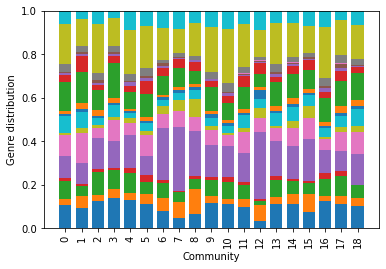

In [89]:
r = np.arange(len(com_df_1))
barwidth = 0.75
bottom_ = np.zeros(len(com_df_1))

for i in com_df_1.drop('n_actors',axis=1).columns:
    bar = com_df_1[i].values
    plt.bar(r, bar, bottom=bottom_, width=barwidth, label=i)
    bottom_ = np.add(bottom_, bar).tolist()

plt.ylim(0,1)
plt.xticks(r, com_df_1.index, rotation='vertical')
plt.xlabel('Community')
plt.ylabel('Genre distribution')
plt.show()

From this plot we see that actors in communities work with one another <b>across</b> genres. This was unexpected, since we had a theory that these communties would be strongly dependent on genre preferences of the actors inside the communities.

It seems that the actor communities are not dependent on the genre. This means that actors in the same community, star together accross different genres, which is an interesting result, because then what drives the community formation?

Now, when we see that actors in each community star together accross all genres, there must be another driver behind why some actors often star in the same movie. This naturally leaves 3 options:

* Actors have preferences with regards to co-stars, and selecting their next movie is dependent on who their co-stars are. An example could be that 2 actors are good friends, and therefore they like doing movies together.


* The public opinion of the on-screen relationship between the 2 actors. Because the public likes to see the 2 actors together, they are often cast together.


* A combination of the 2 above, which seems like the most likely.

Naturally, 2 actors that dislike each other will not star together often, and casters won't cast 2 actors together often, if the public dislikes them on screen together. Therefore it seems more likely that a combination of the two determines which community an actor is in.

### Community Conclusion

Unfortunately the detected communities we not even weak communities, and therefore it can be difficult to draw conclusions on what determines, what is the main driver behind the community an actor ends up in. As discussed previously, allowing actors to be present in multiple communities, thus doing link clustering, might be more suitable for our problem, because the network resembles a fur ball, where most actors are connected, which is also emphasized by the very small average shortest path in the network.

Ignoring the fact that our communities are of poor quality, it still seems that communities are not driven by genres, which is an interesting observation. Being independent of genre, one could argue that personal relationships between actors, is a driver for who is often co-starring in movies.

## <span style="color:red">Section wrap up</span>


Insert data etc.

# <span style="color:red">Final thoughts</span>
